In [23]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device: {}".format(device))

Device: cpu


In [24]:
import numpy as np
import os
from get_data import get_data
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.tensorflow import balanced_batch_generator
from numpy.random import default_rng
rng = default_rng(seed = 31)
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
import geopandas as gpd
import shapely
import libpysal
import matplotlib.pyplot as plt
from copy import deepcopy

In [25]:
from torch import nn, optim
import scipy.ndimage as ndimage

In [26]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [27]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        print(filename)
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
        
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
#     df.plot(figsize = (40,40), column = "y")
#     plt.show()
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df 

In [28]:
# df15 = load_data(2015)
# df16 = load_data(2016)
df17 = load_data(2017)
df18 = load_data(2018)
df19 = load_data(2019)

wt = libpysal.weights.DistanceBand.from_dataframe(df17, threshold=150, binary = True, silence_warnings = True)
wv =libpysal.weights.DistanceBand.from_dataframe(df18, threshold=150, binary = True, silence_warnings = True)
wtest =libpysal.weights.DistanceBand.from_dataframe(df19, threshold=150, binary = True, silence_warnings = True)

eindhoven17.csv_filled_.csv
eindhoven18.csv_filled_.csv
eindhoven19.csv_filled_.csv


In [29]:
def create_CNN_samples(grid, block, dims = 39):
    
    nonzero = np.transpose(grid[:,:,-2].nonzero()) # Get indices of nonzero componetns
    size = nonzero.shape[0]
    width = block * 2 + 1 # calculate widht and height. Needed later on
    
    X = np.zeros((size, width, width, dims))
    Y = np.zeros(size)
    ID = np.zeros(size)
    Y_1 = np.zeros(size)
    
    for idx, i in enumerate(nonzero):
        x, ID[idx], Y[idx], Y_1[idx] = get_neighbor_grid(grid, i, block)
        X[idx] = x.reshape(width,width, dims)
        
    X = np.moveaxis(X, -1, 1) # order the indices correctly to make sure it works in CNN
    X = torch.from_numpy(X).float()
    Y = torch.from_numpy(Y).float()
    
    return X,ID,Y, Y_1

In [30]:
def get_neighbor_grid(full, hw, block = 1):
    
    # get the nonzero (built) blocks by checking if they have a ID

    h = hw[0]
    w = hw[1]
    
    y = full[h,w,-1]
    ID = full[h,w,-2]
    Y_1_train = full[h,w,-3]
    
    hu = h - block
    hd = h + block
    hshort, hextra, wshort, wextra = 0,0,0,0
    if hu < 0:
        hshort = 0 - hu
        hu = 0
    if hd >= full.shape[0]:
        hextra = (hd - full.shape[0]) + 1
        hd = full.shape[0]

    wr = w + block
    wl = w - block

    if wr >= full.shape[1]:
        wextra = (wr - full.shape[1]) + 1
        wr = full.shape[1]
    if wl < 0:
        wshort = 0 - wl
        wl = 0

    nb = full[hu : hd + 1, wl : wr + 1, :]
    nb = np.pad(nb, ((hshort, hextra), (wshort, wextra), (0,0)), mode = "constant", constant_values = 0)
    return nb[:,:,:-3], ID, y, Y_1_train


In [31]:

##  trainingset
X_train = []
Y_train = []
ID_train = []
Y_1_train = []
for filename in os.listdir("../Data/filled/grids/2017/"):
    n = np.load("../Data/filled/grids/2017/" + filename)
    print(filename)
    X, ID, Y, Y_1 = create_CNN_samples(n, 10)
    X_train.append(X)
    Y_train.append(Y)
    ID_train.append(ID)
    Y_1_train.append(Y_1)
    
block_size = X.shape[-1]
    
Y_train = np.concatenate(Y_train)
ID_train = np.concatenate(ID_train)
X_train = np.concatenate(X_train)

# create Y_1_train
Y_1_train = np.concatenate(Y_1_train)
neighbors = [wt.neighbors[x] for x in wt.neighbors]
Y_1_train = np.array([Y_1_train[x].sum() for x in neighbors])
Y_1_train[np.where(Y_1_train == 0)[0]] = 0.5

#reshape to rescale
X_train = np.moveaxis(X_train, 1, -1)
X_train = X_train.reshape(-1, 39)
X_train = ss.fit_transform(X_train) #rescale

# reshape to oversample, append y_1 to resample
X_train = X_train.reshape(-1, block_size, block_size, 39)
X_train = X_train.reshape(X_train.shape[0], -1)
print(X_train.shape)
X_train = np.append(X_train, Y_1_train.reshape(-1,1), axis = 1)

oversampler = SMOTE() #resample
X_train_resamp, Y_train_resamp = oversampler.fit_resample(X_train, Y_train)

del(X_train)
del(Y_train)

# 0.5 means no neighbors, otherwise make int
X_train_resamp[X_train_resamp[:,-1]>0.5][:,-1] =  np.ceil(X_train_resamp[X_train_resamp[:,-1] > 0.5][:,-1]) 
Y_1_train_resamp = X_train_resamp[:,-1]
X_train_resamp = np.delete(X_train_resamp, 39, 1)

# reshape to grid
X_train_resamp = X_train_resamp.reshape(-1, block_size, block_size, 39)
print(X_train_resamp.shape)
# move axis for pytorch
X_train_resamp = np.moveaxis(X_train_resamp, -1, 1) 
print(X_train_resamp.shape)



## validation set
X_val = []
Y_val = []
ID_val = []
Y_1_val = []

for filename in os.listdir("../Data/filled/grids/2018/"):
    n = np.load("../Data/filled/grids/2018/" + filename)
    X, ID, Y, Y_1 = create_CNN_samples(n, 10)
    X_val.append(X)
    Y_val.append(Y)
    ID_val.append(ID)
    Y_1_val.append(Y_1)
    
# create and transform X_val
X_val = np.concatenate(X_val)
X_val = np.moveaxis(X_val, 1, -1)
X_val = X_val.reshape(-1, 39)
X_val = ss.transform(X_val)
X_val = X_val.reshape(-1, block_size, block_size, 39)
X_val = np.moveaxis(X_val, -1, 1)

# create Y_1_val
Y_1_val = np.concatenate(Y_1_val)
neighbors = [wv.neighbors[x] for x in wv.neighbors]
Y_1_val = np.array([Y_1_val[x].sum() for x in neighbors])
Y_1_val[np.where(Y_1_val == 0)[0]] = 0.5

# create Y-val and ID_val
Y_val = np.concatenate(Y_val)
ID_val = np.concatenate(ID_val)

## test set
X_test = []
Y_test = []
ID_test = []
Y_1_test = []

for filename in os.listdir("../Data/filled/grids/2019/"):
    n = np.load("../Data/filled/grids/2019/" + filename)
    X, ID, Y, Y_1 = create_CNN_samples(n, 10)
    X_test.append(X)
    Y_test.append(Y)
    ID_test.append(ID)
    Y_1_test.append(Y_1)
    
# create and transform X_test
X_test = np.concatenate(X_test)
X_test = np.moveaxis(X_test, 1, -1)
X_test = X_test.reshape(-1, 39)
X_test = ss.transform(X_test)
X_test = X_test.reshape(-1, block_size, block_size, 39)
X_test = np.moveaxis(X_test, -1, 1)

# create Y_1_test
Y_1_test = np.concatenate(Y_1_test)
neighbors = [wtest.neighbors[x] for x in wtest.neighbors]
Y_1_test = np.array([Y_1_test[x].sum() for x in neighbors])
Y_1_test[np.where(Y_1_test == 0)[0]] = 0.5

# create Y-test and ID_test
Y_test = np.concatenate(Y_test)
ID_test = np.concatenate(ID_test)

ndhoven17.npy
(6204, 17199)
(11410, 21, 21, 39)
(11410, 39, 21, 21)


In [32]:
X_val = torch.tensor(X_val).float().to(device)
Y_1_val = torch.tensor(Y_1_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
Y_1_test = torch.tensor(Y_1_test).float().to(device)

In [33]:
def get_batch(X, Y, Y1, batch_size = 32):
    
    idxs = rng.integers(X.shape[0], size = batch_size)
    
    X = torch.from_numpy(X[idxs]).float()
    Y = torch.from_numpy(Y[idxs]).float()
    Y1 = torch.from_numpy(Y1[idxs]).float()

    return X, Y, Y1


In [34]:
class Model2(nn.Module): # best auc = 0.58
    def __init__(self):
        super(Model2, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels= 39, out_channels = 15, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 15, out_channels = 20, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 20, out_channels = 5, kernel_size = (3,3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(5, 1)
            )
        
        self.final = nn.Sigmoid()
        
    def forward(self, x, y1):
#         for i in self.net:
            
        out = self.net(x)
        out = out.squeeze() * y1
        return out

In [35]:
class Model1(nn.Module): # best auc = 0.58
    def __init__(self):
        super(Model1, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels= 39, out_channels = 15, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 15, out_channels = 20, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten(),
            nn.Linear(180 , 150),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(150,1)
            )
        
        self.final = nn.Sigmoid()
        
    def forward(self, x, y1):
#         for i in self.net:
            
        out = self.net(x)
        out = out.squeeze() * y1
        return out

In [36]:

class Model3(nn.Module): # best auc = 0.58
    def __init__(self):
        super(Model3, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels= 39, out_channels = 5, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 5, out_channels = 5, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten(),
            nn.Linear(45, 1)
            )
        
        self.final = nn.Sigmoid()
        
    def forward(self, x, y1):
#         for i in self.net:
            
        out = self.net(x)
        out = out.squeeze() * y1
        return out

In [37]:
class Model(nn.Module): # best auc = 0.58
    def __init__(self):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels= 39, out_channels = 5, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels = 5, out_channels = 15, kernel_size = (4,4)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Flatten(),
            nn.Linear(135, 150),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(150,1)
            )
        
        self.final = nn.Sigmoid()
        
    def forward(self, x, y1):
#         for i in self.net:
            
        out = self.net(x)
        out = out.squeeze() * y1
        return out

In [38]:
model = Model().to(device)
model1 = Model1().to(device)
model2 = Model2().to(device)
model3 = Model3().to(device)

models = ["0", "1", "2", "3"]
# models = ["2"]

In [39]:
def train(models, X_train, Y_train, Y1_train, X_val, Y_val, Y1_val, num_epochs, lr, batch_per_e = 100 ):

    best_auc, best_f1, best_model, best_epoch, best_lr = 0,0,0,0,0
    
    for i, model in enumerate(models):
        for lr in [ 0.0000051, 0.00000051 ]:
#         for lr in [0.000051]:
            

            if model == "0":
                model = Model()
            elif model == "1":
                model = Model1()
            elif model == "2":
                model = Model2()
            else:
                model = Model3()
                    
            optimizer = optim.Adam(model.parameters(), lr=lr) 
            SigBCEloss = nn.BCEWithLogitsLoss()
            ROC_history = []

            for epoch in range(num_epochs):
                epoch_loss = []
                print("epoch: {} of {}".format(epoch, num_epochs))
                for batch in range(batch_per_e):

                    x, y, y1 = get_batch(X_train, Y_train, Y1_train, 6)

                    model.train()

                    optimizer.zero_grad()
                    out = model(x, y1).squeeze()


                    loss = SigBCEloss(out, y)
                    loss.backward()
                    optimizer.step()


                    epoch_loss.append(loss.detach().numpy())

                model.eval()

                out = model(X_val, Y1_val)
                ROC = roc_auc_score(Y_val, model.final(out).detach().numpy())
                out = out.squeeze().detach().numpy()

                preds = np.zeros(len(out))
                pos = out.argsort()[-((Y_val == 1).sum()):]
                preds[pos] = 1
                
                f1 = f1_score(Y_val, preds)

                ROC_history.append(ROC)

                if ROC > best_auc:
                    print("model: {}, ROC:{}, f1: {}, lr: {}, epoch = {}".format(i, ROC, f1, lr, epoch))
                    best_auc = ROC
                    best_f1 = f1
                    best_model = deepcopy(model.state_dict())
                    best_epoch = epoch
                    best_lr = lr

                train_loss = []
                          
            print(np.max(ROC_history), np.argmax(ROC_history), lr)
            plt.plot(ROC_history, alpha = 0.5)
            plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r") 
            linear_model=np.polyfit(range(n_epochs), ROC_history, 2)
            linear_model_fn=np.poly1d(linear_model)
            x_s=np.arange(0,n_epochs)
            plt.plot(linear_model_fn(x_s))  
            plt.show()
                          
    result = np.argmax(ROC_history)
    return best_auc, best_f1, best_model, best_epoch

epoch: 0 of 150
model: 0, ROC:0.5942107977206117, f1: 0.13389121338912133, lr: 5.1e-06, epoch = 0
epoch: 1 of 150
model: 0, ROC:0.5949088730634302, f1: 0.13598326359832635, lr: 5.1e-06, epoch = 1
epoch: 2 of 150
model: 0, ROC:0.5961231615233926, f1: 0.13598326359832635, lr: 5.1e-06, epoch = 2
epoch: 3 of 150
model: 0, ROC:0.5967782644360167, f1: 0.13807531380753138, lr: 5.1e-06, epoch = 3
epoch: 4 of 150
model: 0, ROC:0.5985301615690848, f1: 0.13807531380753138, lr: 5.1e-06, epoch = 4
epoch: 5 of 150
model: 0, ROC:0.5992944180807679, f1: 0.1401673640167364, lr: 5.1e-06, epoch = 5
epoch: 6 of 150
model: 0, ROC:0.5992949620355804, f1: 0.14435146443514643, lr: 5.1e-06, epoch = 6
epoch: 7 of 150
model: 0, ROC:0.6004448825093869, f1: 0.14853556485355648, lr: 5.1e-06, epoch = 7
epoch: 8 of 150
model: 0, ROC:0.6010657162688181, f1: 0.14644351464435146, lr: 5.1e-06, epoch = 8
epoch: 9 of 150
model: 0, ROC:0.601379759513951, f1: 0.14853556485355648, lr: 5.1e-06, epoch = 9
epoch: 10 of 150
epoch

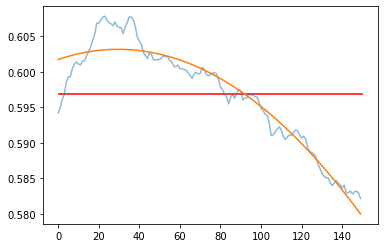

epoch: 0 of 150
model: 0, ROC:0.6087430944936542, f1: 0.15271966527196654, lr: 5.1e-07, epoch = 0
epoch: 1 of 150
epoch: 2 of 150
epoch: 3 of 150
epoch: 4 of 150
epoch: 5 of 150
epoch: 6 of 150
epoch: 7 of 150
epoch: 8 of 150
epoch: 9 of 150
epoch: 10 of 150
epoch: 11 of 150
epoch: 12 of 150
epoch: 13 of 150
epoch: 14 of 150
epoch: 15 of 150
epoch: 16 of 150
epoch: 17 of 150
epoch: 18 of 150
epoch: 19 of 150
epoch: 20 of 150
epoch: 21 of 150
epoch: 22 of 150
epoch: 23 of 150
epoch: 24 of 150
epoch: 25 of 150
epoch: 26 of 150
epoch: 27 of 150
epoch: 28 of 150
epoch: 29 of 150
epoch: 30 of 150
epoch: 31 of 150
epoch: 32 of 150
epoch: 33 of 150
epoch: 34 of 150
epoch: 35 of 150
epoch: 36 of 150
epoch: 37 of 150
epoch: 38 of 150
epoch: 39 of 150
epoch: 40 of 150
epoch: 41 of 150
epoch: 42 of 150
epoch: 43 of 150
epoch: 44 of 150
epoch: 45 of 150
epoch: 46 of 150
epoch: 47 of 150
epoch: 48 of 150
epoch: 49 of 150
epoch: 50 of 150
epoch: 51 of 150
epoch: 52 of 150
epoch: 53 of 150
epoch: 54 

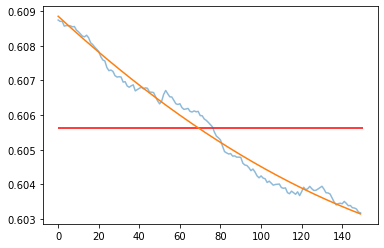

epoch: 0 of 150
epoch: 1 of 150
epoch: 2 of 150
epoch: 3 of 150
epoch: 4 of 150
epoch: 5 of 150
epoch: 6 of 150
epoch: 7 of 150
epoch: 8 of 150
epoch: 9 of 150
epoch: 10 of 150
epoch: 11 of 150
epoch: 12 of 150
epoch: 13 of 150
epoch: 14 of 150
epoch: 15 of 150
epoch: 16 of 150
epoch: 17 of 150
epoch: 18 of 150
epoch: 19 of 150
epoch: 20 of 150
epoch: 21 of 150
epoch: 22 of 150
epoch: 23 of 150
epoch: 24 of 150
epoch: 25 of 150
epoch: 26 of 150
epoch: 27 of 150
epoch: 28 of 150
epoch: 29 of 150
epoch: 30 of 150
epoch: 31 of 150
epoch: 32 of 150
epoch: 33 of 150
epoch: 34 of 150
epoch: 35 of 150
epoch: 36 of 150
epoch: 37 of 150
epoch: 38 of 150
epoch: 39 of 150
epoch: 40 of 150
epoch: 41 of 150
epoch: 42 of 150
epoch: 43 of 150
epoch: 44 of 150
epoch: 45 of 150
epoch: 46 of 150
epoch: 47 of 150
epoch: 48 of 150
epoch: 49 of 150
epoch: 50 of 150
epoch: 51 of 150
epoch: 52 of 150
epoch: 53 of 150
epoch: 54 of 150
epoch: 55 of 150
epoch: 56 of 150
epoch: 57 of 150
epoch: 58 of 150
epoch: 

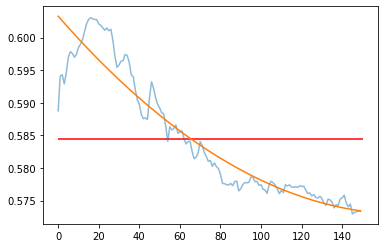

epoch: 0 of 150
epoch: 1 of 150
epoch: 2 of 150
epoch: 3 of 150
epoch: 4 of 150
epoch: 5 of 150
epoch: 6 of 150
epoch: 7 of 150
epoch: 8 of 150
epoch: 9 of 150
epoch: 10 of 150
epoch: 11 of 150
epoch: 12 of 150
epoch: 13 of 150
epoch: 14 of 150
epoch: 15 of 150
epoch: 16 of 150
epoch: 17 of 150
epoch: 18 of 150
epoch: 19 of 150
epoch: 20 of 150
epoch: 21 of 150
epoch: 22 of 150
epoch: 23 of 150
epoch: 24 of 150
epoch: 25 of 150
epoch: 26 of 150
epoch: 27 of 150
epoch: 28 of 150
epoch: 29 of 150
epoch: 30 of 150
epoch: 31 of 150
epoch: 32 of 150
epoch: 33 of 150
epoch: 34 of 150
epoch: 35 of 150
epoch: 36 of 150
epoch: 37 of 150
epoch: 38 of 150
epoch: 39 of 150
epoch: 40 of 150
epoch: 41 of 150
epoch: 42 of 150
epoch: 43 of 150
epoch: 44 of 150
epoch: 45 of 150
epoch: 46 of 150
epoch: 47 of 150
epoch: 48 of 150
epoch: 49 of 150
epoch: 50 of 150
epoch: 51 of 150
epoch: 52 of 150
epoch: 53 of 150
epoch: 54 of 150
epoch: 55 of 150
epoch: 56 of 150
epoch: 57 of 150
epoch: 58 of 150
epoch: 

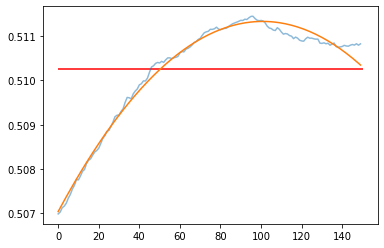

epoch: 0 of 150
epoch: 1 of 150
epoch: 2 of 150
epoch: 3 of 150
epoch: 4 of 150
epoch: 5 of 150
epoch: 6 of 150
epoch: 7 of 150
epoch: 8 of 150
epoch: 9 of 150
epoch: 10 of 150
epoch: 11 of 150
epoch: 12 of 150
epoch: 13 of 150
epoch: 14 of 150
epoch: 15 of 150
epoch: 16 of 150
epoch: 17 of 150
epoch: 18 of 150
epoch: 19 of 150
epoch: 20 of 150
epoch: 21 of 150
epoch: 22 of 150
epoch: 23 of 150
epoch: 24 of 150
epoch: 25 of 150
epoch: 26 of 150
epoch: 27 of 150
epoch: 28 of 150
epoch: 29 of 150
epoch: 30 of 150
epoch: 31 of 150
epoch: 32 of 150
epoch: 33 of 150
epoch: 34 of 150
epoch: 35 of 150
epoch: 36 of 150
epoch: 37 of 150
epoch: 38 of 150
epoch: 39 of 150
epoch: 40 of 150
epoch: 41 of 150
epoch: 42 of 150
epoch: 43 of 150
epoch: 44 of 150
epoch: 45 of 150
epoch: 46 of 150
epoch: 47 of 150
epoch: 48 of 150
epoch: 49 of 150
epoch: 50 of 150
epoch: 51 of 150
epoch: 52 of 150
epoch: 53 of 150
epoch: 54 of 150
epoch: 55 of 150
epoch: 56 of 150
epoch: 57 of 150
epoch: 58 of 150
epoch: 

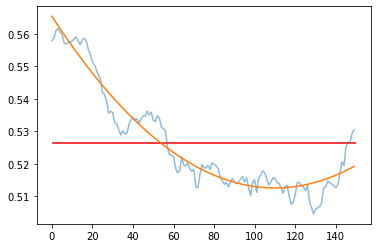

epoch: 0 of 150
epoch: 1 of 150
epoch: 2 of 150
epoch: 3 of 150
epoch: 4 of 150
epoch: 5 of 150
epoch: 6 of 150
epoch: 7 of 150
epoch: 8 of 150
epoch: 9 of 150
epoch: 10 of 150
epoch: 11 of 150
epoch: 12 of 150
epoch: 13 of 150
epoch: 14 of 150
epoch: 15 of 150
epoch: 16 of 150
epoch: 17 of 150
epoch: 18 of 150
epoch: 19 of 150
epoch: 20 of 150
epoch: 21 of 150
epoch: 22 of 150
epoch: 23 of 150
epoch: 24 of 150
epoch: 25 of 150
epoch: 26 of 150
epoch: 27 of 150
epoch: 28 of 150
epoch: 29 of 150
epoch: 30 of 150
epoch: 31 of 150
epoch: 32 of 150
epoch: 33 of 150
epoch: 34 of 150
epoch: 35 of 150
epoch: 36 of 150
epoch: 37 of 150
epoch: 38 of 150
epoch: 39 of 150
epoch: 40 of 150
epoch: 41 of 150
epoch: 42 of 150
epoch: 43 of 150
epoch: 44 of 150
epoch: 45 of 150
epoch: 46 of 150
epoch: 47 of 150
epoch: 48 of 150
epoch: 49 of 150
epoch: 50 of 150
epoch: 51 of 150
epoch: 52 of 150
epoch: 53 of 150
epoch: 54 of 150
epoch: 55 of 150
epoch: 56 of 150
epoch: 57 of 150
epoch: 58 of 150
epoch: 

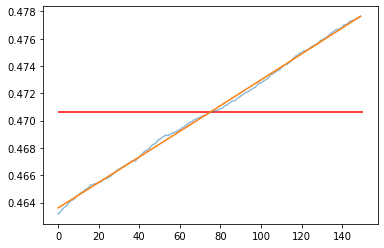

epoch: 0 of 150
epoch: 1 of 150
epoch: 2 of 150
epoch: 3 of 150
epoch: 4 of 150
epoch: 5 of 150
epoch: 6 of 150
epoch: 7 of 150
epoch: 8 of 150
epoch: 9 of 150
epoch: 10 of 150
epoch: 11 of 150
epoch: 12 of 150
epoch: 13 of 150
epoch: 14 of 150
epoch: 15 of 150
epoch: 16 of 150
epoch: 17 of 150
epoch: 18 of 150
epoch: 19 of 150
epoch: 20 of 150
epoch: 21 of 150
epoch: 22 of 150
epoch: 23 of 150
epoch: 24 of 150
epoch: 25 of 150
epoch: 26 of 150
epoch: 27 of 150
epoch: 28 of 150
epoch: 29 of 150
epoch: 30 of 150
epoch: 31 of 150
epoch: 32 of 150
epoch: 33 of 150
epoch: 34 of 150
epoch: 35 of 150
epoch: 36 of 150
epoch: 37 of 150
epoch: 38 of 150
epoch: 39 of 150
epoch: 40 of 150
epoch: 41 of 150
epoch: 42 of 150
epoch: 43 of 150
epoch: 44 of 150
epoch: 45 of 150
epoch: 46 of 150
epoch: 47 of 150
epoch: 48 of 150
epoch: 49 of 150
epoch: 50 of 150
epoch: 51 of 150
epoch: 52 of 150
epoch: 53 of 150
epoch: 54 of 150
epoch: 55 of 150
epoch: 56 of 150
epoch: 57 of 150
epoch: 58 of 150
epoch: 

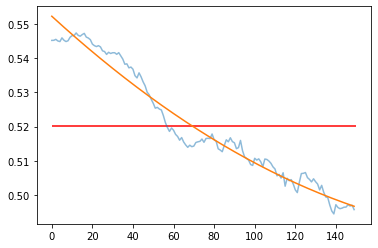

epoch: 0 of 150
epoch: 1 of 150
epoch: 2 of 150
epoch: 3 of 150
epoch: 4 of 150
epoch: 5 of 150
epoch: 6 of 150
epoch: 7 of 150
epoch: 8 of 150
epoch: 9 of 150
epoch: 10 of 150
epoch: 11 of 150
epoch: 12 of 150
epoch: 13 of 150
epoch: 14 of 150
epoch: 15 of 150
epoch: 16 of 150
epoch: 17 of 150
epoch: 18 of 150
epoch: 19 of 150
epoch: 20 of 150
epoch: 21 of 150
epoch: 22 of 150
epoch: 23 of 150
epoch: 24 of 150
epoch: 25 of 150
epoch: 26 of 150
epoch: 27 of 150
epoch: 28 of 150
epoch: 29 of 150
epoch: 30 of 150
epoch: 31 of 150
epoch: 32 of 150
epoch: 33 of 150
epoch: 34 of 150
epoch: 35 of 150
epoch: 36 of 150
epoch: 37 of 150
epoch: 38 of 150
epoch: 39 of 150
epoch: 40 of 150
epoch: 41 of 150
epoch: 42 of 150
epoch: 43 of 150
epoch: 44 of 150
epoch: 45 of 150
epoch: 46 of 150
epoch: 47 of 150
epoch: 48 of 150
epoch: 49 of 150
epoch: 50 of 150
epoch: 51 of 150
epoch: 52 of 150
epoch: 53 of 150
epoch: 54 of 150
epoch: 55 of 150
epoch: 56 of 150
epoch: 57 of 150
epoch: 58 of 150
epoch: 

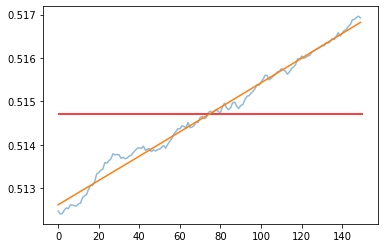

In [40]:
n_epochs = 150
a = train(models, X_train_resamp, Y_train_resamp, Y_1_train_resamp, X_val, Y_val, Y_1_val, n_epochs, 0.00000051)

In [47]:
model = Model3()
model.load_state_dict(a[2])
model.eval()

out = model(X_test, Y_1_test)

ROC = roc_auc_score(Y_test, model.final(out).detach().numpy())
out = out.squeeze().detach().numpy()

preds = np.zeros(len(out))
pos = out.argsort()[-((Y_test == 1).sum()):]
preds[pos] = 1

f1 = f1_score(Y_test, preds)
print(ROC, f1)
# with open ("../Results/Nijmegen.csv", "a+") as f:
#     f.write("\nCNN,{},{}".format(ROC,f1))

0.5996451911965481 0.15749525616698293


In [45]:
import pickle
f = open('../results/EHCNNpreds','wb')
pickle.dump(out,f)
f.close()

In [46]:
with open ("../Results/modellen.csv", "a+") as f:
    f.write("EH,CNN,model\n")

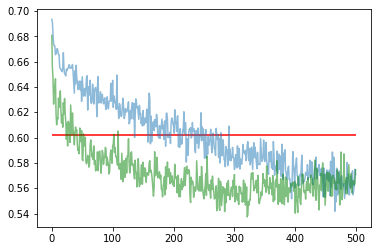

In [84]:
plt.plot(a[-3], alpha = 0.5)
plt.hlines(np.mean(a[-3]), 0, n_epochs, color = "r")
plt.plot(a[-1], alpha = 0.5, color = "green")

0.5738016677005341


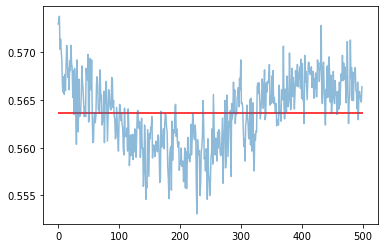

In [85]:
print(np.max(a[-4]))
plt.plot(a[-4], alpha = 0.5)
plt.hlines(np.mean(a[-4]), 0, n_epochs, color = "r")

0.23703917050691245


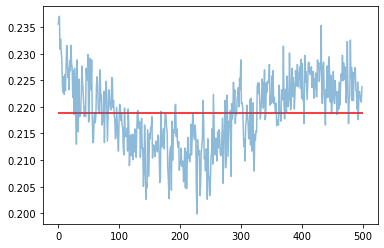

In [86]:
print(np.max(a[-2]))
plt.plot(a[-2], alpha = 0.5)
plt.hlines(np.mean(a[-2]), 0, n_epochs, color = "r")

In [59]:
a

(0.6369707441554655,
 0.30893300248138955,
 OrderedDict([('net.0.weight',
               tensor([[[[ 1.2092e-02,  1.2006e-02, -4.3649e-03, -1.1921e-02],
                         [ 1.6450e-02,  2.1175e-02,  3.7239e-02, -9.0888e-03],
                         [-3.1068e-03, -7.4035e-03, -2.3311e-02,  1.1685e-02],
                         [ 2.3203e-02,  5.1307e-03,  3.7194e-02,  3.3867e-02]],
               
                        [[-4.0822e-02,  1.4476e-03, -3.4444e-02,  1.3408e-02],
                         [-2.9764e-02,  2.5528e-02, -1.5390e-02,  1.5146e-02],
                         [ 1.2707e-02,  1.7593e-02,  3.5842e-02, -1.4406e-02],
                         [ 1.5483e-02, -1.0377e-02, -2.7588e-02,  1.0708e-02]],
               
                        [[-3.1919e-02,  3.3267e-02, -2.6323e-02, -1.1467e-02],
                         [-1.6676e-02, -2.8794e-02, -5.8882e-03,  4.3409e-02],
                         [-2.6704e-02,  4.8104e-03, -1.8750e-02,  2.2671e-02],
                       

BEST CNN FOUND Den haaG: AUC 0.636, model: 2, lr = 5.1e-06


In [32]:
def neighbor_part(model, X, idxs, w):
    preds = model(X)
    preds = pd.DataFrame(np.array(preds.detach())).set_index(idxs)
    
    neighbors = [w.neighbors[x] for x in idxs]
    transitions = [preds.loc[x].values for x in neighbors]



    n_function = np.zeros((len(preds), w.max_neighbors + 1))
    for i, (t, idx) in enumerate(zip(transitions, idxs)):
        n_function[i, 1:len(t) + 1] = t.squeeze()
        n_function[i, 0] = preds.loc[idx]
        
    return n_function

In [ ]:
class Model(nn.Module): # best auc = 0.59
    def __init__(self, name):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels= 39, out_channels = 60, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(), 
            nn.Dropout2d(0.25),
            nn.Conv2d(in_channels = 60, out_channels = 60, kernel_size = (3,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.Flatten(),
            nn.Linear(60, 1))
        
        self.final = nn.Sigmoid()
        self.name = name
        
    def forward(self, x, y1):
#         for i in self.net:
            
        out = self.net(x)
        out = out.squeeze() * y1
        return out

# Neighbor function

In [34]:
import geopandas as gpd
import shapely
import libpysal

def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [35]:
df15 = load_data(2015)
df16 = load_data(2016)
wt = libpysal.weights.DistanceBand.from_dataframe(df15, threshold=150, binary = True, silence_warnings = True)
wv = libpysal.weights.DistanceBand.from_dataframe(df16, threshold=150, binary = True, silence_warnings = True)

In [36]:

scaler = StandardScaler()
X15 = df15[df15.columns[:-4]]
Y15 = df15.y

X16 = df16[df16.columns[:-4]]
Y16 = df16.y

X15 = pd.DataFrame(scaler.fit_transform(X15))
X16 = pd.DataFrame(scaler.transform(X16))

In [51]:
cluster_model = KMeans(n_clusters=5, random_state=0)
labels15 = pd.DataFrame(cluster_model.fit_predict(X15))
labels16 = pd.DataFrame(cluster_model.predict(X16))

labels15["X"] = X15.index
labels16["X"] = X16.index


labels15 = labels15.set_index(0)
labels16 = labels16.set_index(0)

In [42]:
with open('cbs_id_koppel.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [43]:
# br.C28992R100 = br.C28992R100.map(b) # change C28992code for id
labels15.C28 = labels15.C28.map(b)

In [48]:
labels15

,X,C28
0,,
0,0,2748208
0,1,2748211
0,2,2748212
0,3,2748245
0,4,2748263
...,...,...
0,56362,1413137
0,56363,1413181
0,56364,1414800


In [53]:
X_train[labels15.loc[0]["X"]].shape

(10237, 39, 11, 11)

In [54]:
labels15.loc[0].shape

(10237, 1)

In [50]:
ID_train

array([2893058., 2870455., 2868833., ..., 1311910., 1176428., 1314791.])

In [84]:

# preds = pd.DataFrame(np.array(preds.detach())).set_index(ID_train)
neighbors = [w15.neighbors[x] for x in ID_train]
transitions = [preds.loc[x].values for x in neighbors]



n_function = np.zeros((len(preds), w15.max_neighbors + 1))
for i, (t, idx) in enumerate(zip(transitions, ID_train)):
    n_function[i, 1:len(t) + 1] = t.squeeze()
    n_function[i, 0] = preds.loc[idx]

In [85]:
params = {"max_depth": [6, 8, 10, 12], "oob_score" : [True, False]}
clf_bagger = GridSearchCV(RandomForestClassifier(), params, cv = 5, scoring = "balanced_accuracy",
                               verbose = 3)
oversample = SMOTE()
x, y = oversample.fit_resample(n_function, Y_train)

clf_bagger.fit(x,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .......max_depth=6, oob_score=True;, score=0.641 total time=   4.8s
[CV 2/5] END .......max_depth=6, oob_score=True;, score=0.649 total time=   4.6s
[CV 3/5] END .......max_depth=6, oob_score=True;, score=0.663 total time=   4.7s
[CV 4/5] END .......max_depth=6, oob_score=True;, score=0.619 total time=   4.8s
[CV 5/5] END .......max_depth=6, oob_score=True;, score=0.681 total time=   4.7s
[CV 1/5] END ......max_depth=6, oob_score=False;, score=0.639 total time=   4.1s
[CV 2/5] END ......max_depth=6, oob_score=False;, score=0.652 total time=   4.3s
[CV 3/5] END ......max_depth=6, oob_score=False;, score=0.663 total time=   4.0s
[CV 4/5] END ......max_depth=6, oob_score=False;, score=0.619 total time=   3.9s
[CV 5/5] END ......max_depth=6, oob_score=False;, score=0.682 total time=   4.4s
[CV 1/5] END .......max_depth=8, oob_score=True;, score=0.647 total time=   5.4s
[CV 2/5] END .......max_depth=8, oob_score=True;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 8, 10, 12],
                         'oob_score': [True, False]},
             scoring='balanced_accuracy', verbose=3)

In [88]:
clf_bagger.best_params_

{'max_depth': 12, 'oob_score': False}

In [ ]:
np.array(preds.detach())

In [90]:
X_val = torch.from_numpy(X_val).float()
preds = model(X_val)

In [91]:
with open('w16.pickle', 'rb') as handle:
    w16 = pickle.load(handle)

In [92]:
preds = pd.DataFrame(np.array(preds.detach())).set_index(ID_val)
neighbors = [w16.neighbors[x] for x in ID_val]
transitions = [preds.loc[x].values for x in neighbors]



n_function = np.zeros((len(preds), w16.max_neighbors + 1))
for i, (t, idx) in enumerate(zip(transitions, ID_val)):
    n_function[i, 1:len(t) + 1] = t.squeeze()
    n_function[i, 0] = preds.loc[idx]

In [93]:
preds = clf_bagger.predict(n_function)

In [94]:
len(neighbors)

57050

In [95]:
clf_bagger.score(n_function, Y_val)

0.5448808332705778

In [96]:
recall_score(Y_val, preds)

0.22256568778979907

In [97]:
precision_score(Y_val, preds)

0.1262683201803833

In [246]:
(Y_val == 1).sum()

4529

# No bagger on the end

In [277]:
preds = pd.DataFrame(np.array(preds.detach())).set_index(ID_val)

In [279]:
preds["y"] = Y_val

In [280]:
preds = preds.sort_values(by=[0], ascending = False)

In [281]:
preds

,0,y
3699708.0,9.999919e-01,0.0
2206980.0,9.999806e-01,0.0
2206983.0,9.999349e-01,0.0
2206982.0,9.999343e-01,0.0
2210563.0,9.999300e-01,0.0
...,...,...
2654130.0,3.897061e-21,0.0
2113362.0,1.054448e-21,0.0
3705586.0,2.995088e-22,0.0
3703981.0,6.478963e-23,0.0


In [282]:
preds[0].iloc[0:4529] = 1
preds[0].iloc[4529:] = 0

In [283]:
recall_score(preds["y"], preds[0])


0.17244424817840584

In [284]:
precision_score(preds["y"], preds[0])

0.17244424817840584